### Домашнее задание 4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
!pip install scikit-uplift catboost==0.22 -U
!pip install causalml

Requirement already up-to-date: scikit-uplift in /usr/local/lib/python3.7/dist-packages (0.3.1)
Requirement already up-to-date: catboost==0.22 in /usr/local/lib/python3.7/dist-packages (0.22)


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [9]:
data_path = '/gdrive/MyDrive/ML in bussines hw/lesson04/data.csv'

In [10]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

In [30]:
df = pd.read_csv(data_path)

In [31]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


##### Подготовка данных
поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [32]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [33]:
df.head(1)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0


In [34]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [35]:
df_rep = {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}

In [36]:
df['treatment'] = df['treatment'].map(df_rep)

In [37]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [38]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.667094,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471257,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


##### сделать разбиение набора данных не тренировочную и тестовую выборки

In [39]:
indices_learn, indices_valid = train_test_split(df.index, test_size=0.3, random_state=123)

In [43]:
features = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']

In [90]:
fs = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral']

In [119]:
X_train = df.loc[indices_learn, :]
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :]
y_val = df.loc[indices_valid, 'target']
treat_val =  df.loc[indices_valid, 'treatment']

cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%': [],
    'uplift@10%': []
}

In [120]:
treat_train.head()

53181    0
42635    1
6296     0
41722    1
32660    1
Name: treatment, dtype: int64

##### сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

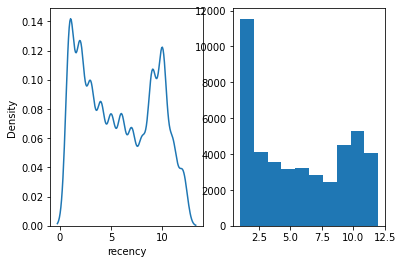

In [122]:
plt.subplot(1,2,1)
sns.kdeplot(X_train['recency'])
plt.subplot(1,2,2)
plt.hist(X_train['recency'])
plt.show()

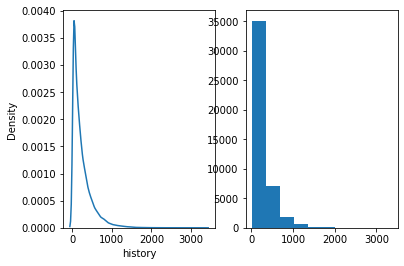

In [123]:
plt.subplot(1,2,1)
sns.kdeplot(X_train['history'])
plt.subplot(1,2,2)
plt.hist(X_train['history'])
plt.show()

recency - months since last purchase

history - $value of the historical purchases

In [124]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler


In [125]:
pT = PowerTransformer(method='box-cox')

In [126]:
x_new = pT.fit_transform(X_train.loc[:,['recency']]+1)
x_new

array([[ 0.70441487],
       [ 0.93196247],
       [-0.06983514],
       ...,
       [-1.53835717],
       [-0.06983514],
       [-1.53835717]])

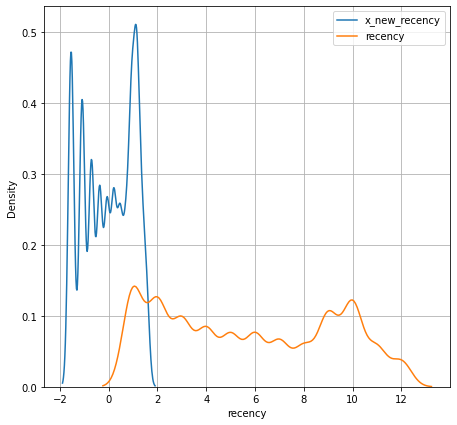

In [127]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.kdeplot(x_new[:,0],label = 'x_new_'+'recency')
sns.kdeplot(X_train['recency'].values, label = 'recency')
plt.xlabel('recency')
plt.legend()
plt.grid('On')
plt.show()

In [128]:
X_train['recency'] = pT.fit_transform(X_train.loc[:,['recency']]+1)

In [129]:
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
53181,0.704415,121.56,0,1,Surburban,0,Web,0,0
42635,0.931962,617.62,0,1,Urban,1,Phone,1,0
6296,-0.069835,185.62,1,0,Rural,1,Web,0,1
41722,-1.538357,359.03,0,1,Rural,0,Web,1,0
32660,1.148129,139.68,1,0,Urban,0,Web,1,0


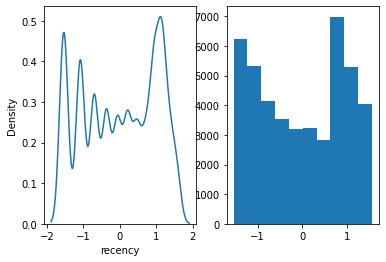

In [130]:
plt.subplot(1,2,1)
sns.kdeplot(X_train['recency'])
plt.subplot(1,2,2)
plt.hist(X_train['recency'])
plt.show()

Кроме применения преобразования к колонке recency, больше не придумал, что можно было бы сделать с данными.

In [131]:
from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt


def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [132]:
X_train = X_train.drop(columns=['treatment', 'target'])

In [133]:
X_train.head(1)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
53181,0.704415,121.56,0,1,Surburban,0,Web


##### Solo Model

CPU times: user 240 ms, sys: 33.6 ms, total: 273 ms
Wall time: 214 ms
Parser   : 155 ms


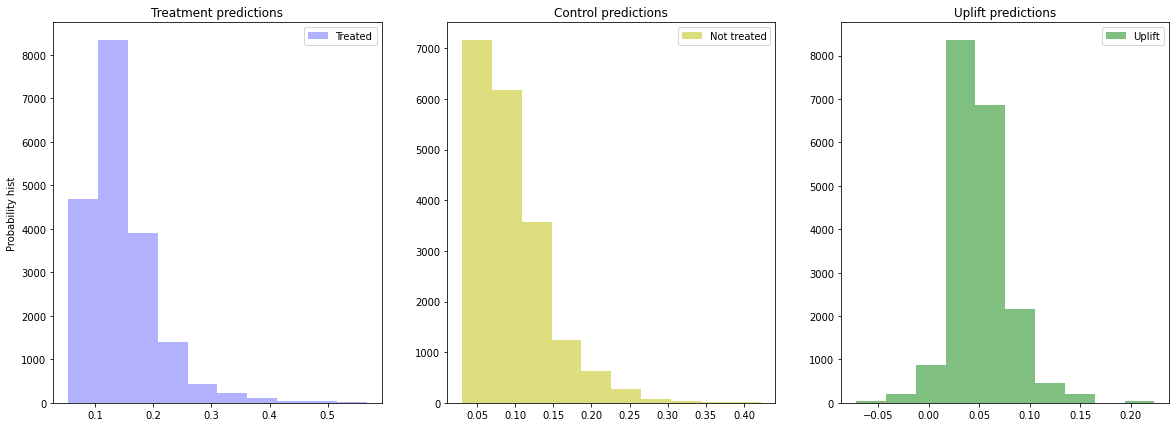

In [134]:
%%time
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds 
from sklift.models import SoloModel

from catboost import CatBoostClassifier

N =10000
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train.iloc[:N,:], y_train.iloc[:N], treat_train.iloc[:N], estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score10 = uplift_at_k(y_true=y_val[:N], uplift=uplift_sm[:N], treatment=treat_val[:N], strategy='by_group', k=0.1)
sm_score20 = uplift_at_k(y_true=y_val[:N], uplift=uplift_sm[:N], treatment=treat_val[:N], strategy='by_group', k=0.2)
sm_score30 = uplift_at_k(y_true=y_val[:N], uplift=uplift_sm[:N], treatment=treat_val[:N], strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)
models_results['uplift@30%'].append(sm_score30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds_(   sm_trmnt_preds , sm_ctrl_preds, bins=10);#ctrl_preds=

Посмотрим на топ-признаки

In [135]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,recency,18.338205
1,history,16.168269
2,treatment,15.968935
3,is_referral,12.447297
4,used_discount,11.624125
5,used_bogo,11.414531
6,zip_code,7.296378
7,channel,6.742259


In [136]:
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.08924857052811669],
 'uplift@20%': [0.0800498927014491],
 'uplift@30%': [0.0789467634585611]}

##### ClassTransformation

In [137]:
%%time
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)
models_results['uplift@30%'].append(ct_score30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


CPU times: user 637 ms, sys: 72.3 ms, total: 709 ms
Wall time: 450 ms


In [138]:
models_results

{'approach': ['SoloModel', 'ClassTransformation'],
 'uplift@10%': [0.08924857052811669, 0.09941238272087569],
 'uplift@20%': [0.0800498927014491, 0.08329150791324735],
 'uplift@30%': [0.0789467634585611, 0.07935711788116262]}

##### Two Models

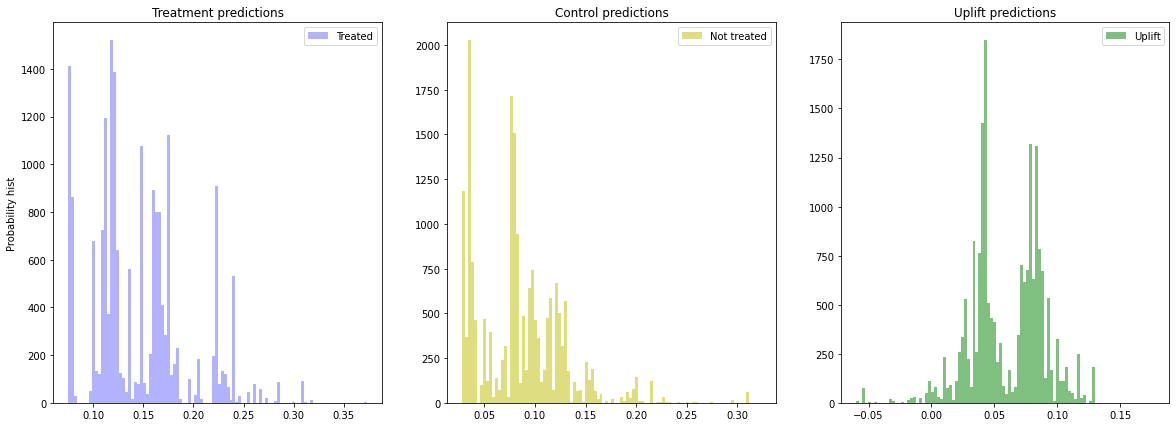

In [139]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)
models_results['uplift@30%'].append(tm_score30)

plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [140]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift@20%,uplift@10%
1,ClassTransformation,0.079357,0.083292,0.099412
0,SoloModel,0.078947,0.080050,0.089249
2,TwoModels,0.074382,0.082506,0.077524


построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

##### Uplift Tree Classifier

In [145]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)
X_val_tree = pd.concat([X_val.drop('zip_code', 1), 
                          pd.get_dummies(X_val['zip_code'], prefix='zip_code')], 1)
# features = [col for col in X_train_tree]

In [146]:
X_train_tree = pd.concat([X_train_tree.drop('channel', 1), 
                          pd.get_dummies(X_train_tree['channel'], prefix='channel')], 1)
X_val_tree = pd.concat([X_val_tree.drop('channel', 1), 
                          pd.get_dummies(X_val_tree['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

In [147]:
X_train_tree.head(1)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
53181,0.704415,121.56,0,1,0,0,1,0,0,0,1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


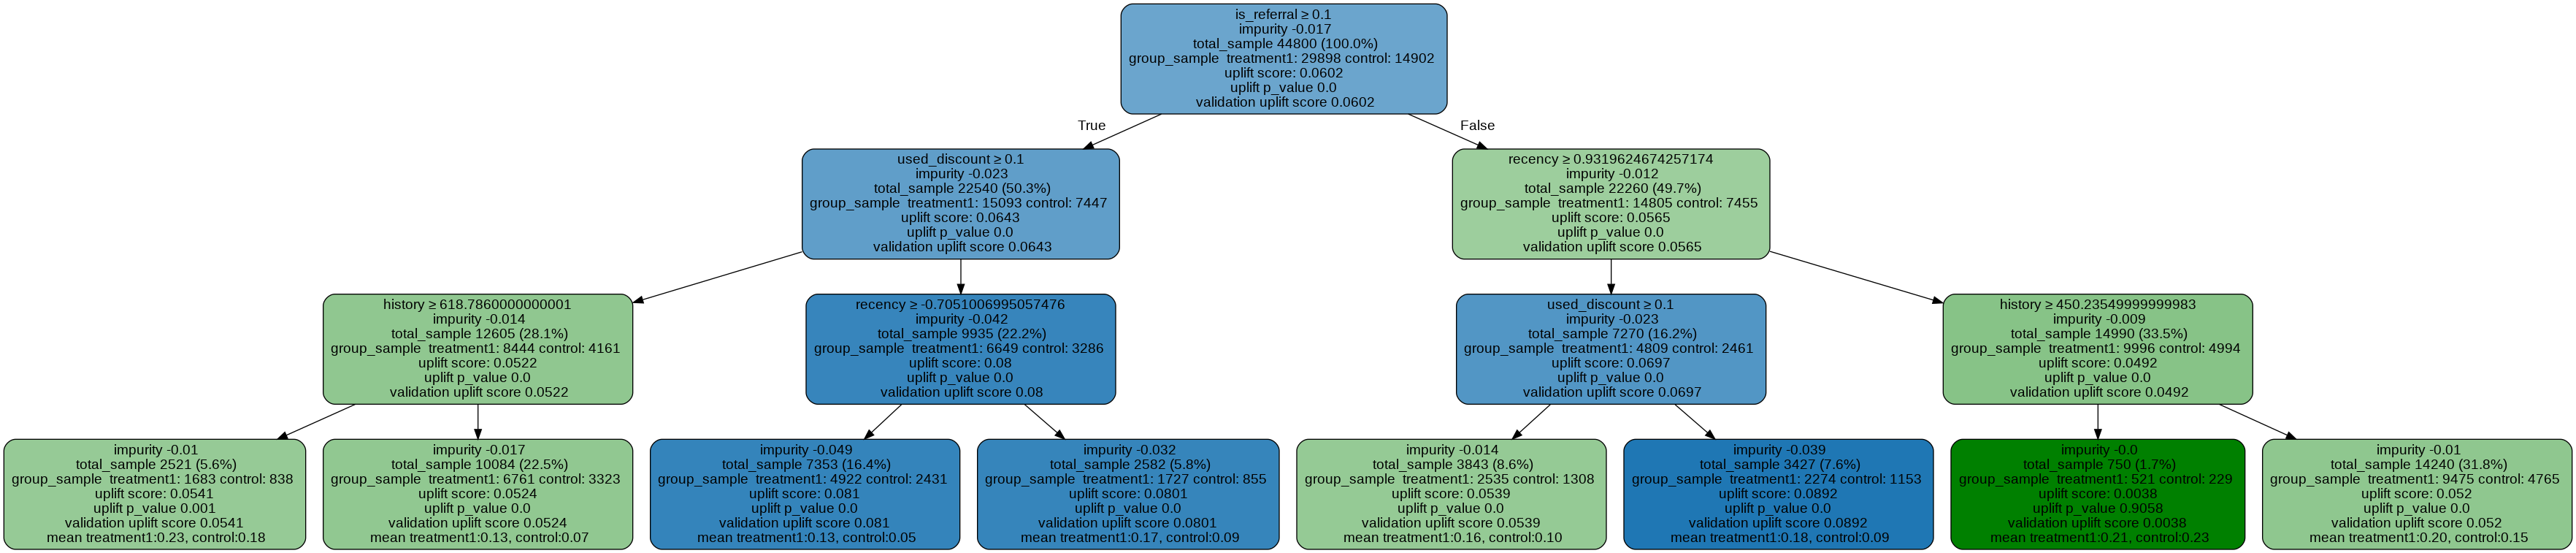

CPU times: user 3.15 s, sys: 335 ms, total: 3.49 s
Wall time: 5.81 s


In [148]:
%%time
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

In [149]:
import numpy as np
tree_lift =  np.array(uplift_model.predict(X_val_tree.values))[0]

uplift_tree_30 = uplift_at_k(y_val, tree_lift, treat_val, strategy='overall')

print(f'uplift@30%: {uplift_tree_30:.4f}')

uplift@30%: 0.0657


In [150]:
X_train['recency'].describe()

count    4.480000e+04
mean    -4.559200e-16
std      1.000011e+00
min     -1.538357e+00
25%     -1.085393e+00
50%     -6.983514e-02
75%      9.319625e-01
max      1.552134e+00
Name: recency, dtype: float64

Наибольший uplift_score имеет пользователь, который пришел не по реферальной программе, последняя покупка была совершена позднее, чем 0.9 (т.к. до преобразования recency был от 1 до 12, после преобразования диапопзон (-1.5, 1.5), то это примерно 9-10 месяцев) и он не пользовался скидками. количество таких пользователей - 7.6%

наименьший uplift_score имеет пользователь, который пришел не по реферальной программе, последняя покупка была совершена не позднее, чем 9-10 назад и всего совершено покупок более, чем на $450. Таких пользователей - 1.7%

##### (опционально)
для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

In [160]:
solo_df = pd.DataFrame({'uplift_sm': uplift_sm, 'y_val': y_val})

In [165]:
solo_df = solo_df.sort_values(by='uplift_sm', ascending=False)

In [183]:
solo_df['Categories'] = pd.qcut(solo_df['uplift_sm'], q=10)

In [190]:
solo_df.head()

,uplift_sm,y_val,Categories
57645,0.223501,0,"(0.0821, 0.224]"
42052,0.221437,0,"(0.0821, 0.224]"
27949,0.221437,0,"(0.0821, 0.224]"
62346,0.221437,0,"(0.0821, 0.224]"
58079,0.221437,1,"(0.0821, 0.224]"


In [189]:
solo_df.groupby('Categories')['y_val'].mean().sort_values(ascending=False)

Categories
(0.0821, 0.224]      0.185345
(-0.0729, 0.0228]    0.167812
(0.0228, 0.0325]     0.167760
(0.0724, 0.0821]     0.165289
(0.0485, 0.0536]     0.139546
(0.0403, 0.0485]     0.139219
(0.0536, 0.0631]     0.139175
(0.035, 0.0403]      0.133772
(0.0631, 0.0724]     0.127392
(0.0325, 0.035]      0.109142
Name: y_val, dtype: float64

##### (опционально)
построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Здесь получаю ошибку. Решение не нашел.


AttributeError: 'UpliftRandomForestClassifier' object has no attribute 'fitted_uplift_tree'

In [232]:
# %%time
uplift_model = UpliftRandomForestClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train.values)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

AttributeError: ignored